# <ins>Polynômes irréductibles et corps finis</ins>

**Les codes correcteurs d'erreurs** jouent un rôle important dans notre société. En outre, ils sont indispensables dans la communication ; ils permettent notamment de corriger des erreurs de transmission dans une image. On peut prendre en guise d'exemple ces deux photos, prises par la sonde *Perseverance* lors de la mission *Mars 2020*, et envoyées sur Terre :

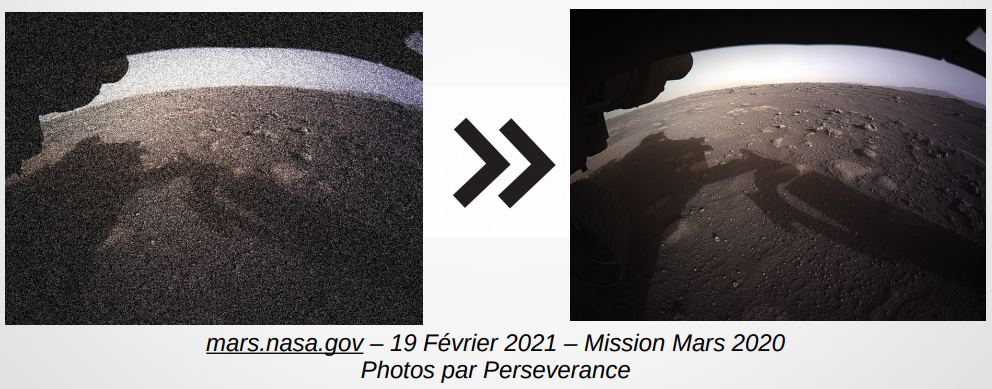

L'image de gauche est une image modifiée, mettant en évidence des erreurs de transmission. Celle de droite est l'image "corrigée", grâce à un code correcteur.
Cela est possible grâce à des données complémentaires dans l'information codée, qui permettent de détecter et de corriger ces erreurs et d'obtenir une image nette, la plus proche possible de l'image envoyée.

<ins>*Un exemple de code correcteur* :</ins> le **numéro de sécurité sociale**.
On sait que ce numéro S est composé de 15 chiffres : *S=100n+c*, avec *n* un nombre à 13 chiffres, et *c* à 2 chiffres.
*c* est <ins>la clé</ins>, comprise entre *1* et *97* tel que *97* divise *n+c*.
On peut donc détecter une erreur dans ce numéro (mais cela ne permet pas de la corriger).

Pour pouvoir construire un code correcteur, il est important de se placer dans un cadre mathématique. Il est nécessaire de passer par des calculs dans des structures de nombres, et les corps finis sont particulièrement adaptés à ces calculs.
Nous allons donc étudier les polynômes irréductibles à coefficients dans un corps premier, puis voir comment construire un corps fini.

Il y a également d'autres aspects (notamment matriciel), disponibles en source **[1]**, mais nous n'allons pas les regarder dans ce Notebook.

*Les références sont disponibles à la toute fin de ce Notebook.*

## <ins>I. Les polynômes irréductibles à coefficients dans Z/*p*Z.</ins>

On peut essayer de construire un corps fini. Pour cela, nous allons nous intéresser au corps fini **Z/*p*Z** où *p* est un nombre premier, et regarder les polynômes irréductibles à coefficients dans **Z/*p*Z[X]**.
Il est possible de déterminer ces polynômes, en utilisant un théorème, basé sur le **test de Rabin** (sources **[2]** et **[3]**) :

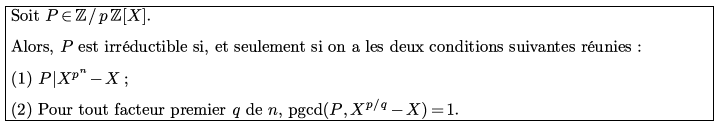

Il est ainsi possible de vérifier informatiquement si un polynôme est irréductible ou pas grâce à un test simple. Mais pour pouvoir le faire, nous aurons besoins de fonctions auxiliaires.

Nous ne nous attarderons pas sur des exemples avant d'arriver à la fonction qui nous intéresse.

Pour information, on considèrera que "le PGCD de 2 polynômes *P* et *Q*" est l'unique PGCD unitaire de *P* et *Q*.

In [1]:
import random as rd
import time
from math import sqrt

Maintenant que nous avons importé les modules qui nous intéresseront pour la suite de ce Notebook, écrivons ces programmes auxiliaires. Nous allons modéliser un polynôme par une liste de coefficients. Par exemple, le polynôme X^3+3X²-3X+7 sera représenté par la liste :

In [2]:
Ex=[7,-3,3,1]

(Il était possible d'utiliser le module `numpy` pour les polynômes, mais j'ai voulu refaire la bibliothèque pour pouvoir adapter les fonctions, étant donné qu'on travaille modulo *p* avec *p* premier.)

Voici quelques fonctions élémentaires qui nous aideront pour construire la fonction qui se base sur le théorème plus haut :

- La fonction qui teste la primalité d'un entier naturel *n* :

In [3]:
def estpremier(n):
    assert n>-1 and n==int(n), "n doit être un entier naturel."
    if n==1 or n%2==0:
        return(n==2)
    d=3
    while d*d<=n:
        if n%d==0:
            return(False)
        d+=2
    return(True)

- La fonction qui teste si un polynôme *P* est nul, c'est-à-dire si la liste qui le représente est vide ou une liste avec que des zéros :

In [4]:
def estnul(P):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    for c in P:
        if c!=0:
            return(False)
    return(True)

- La fonction qui renvoie le degré d'un polynôme *P* :

In [5]:
def deg(P):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    if estnul(P):
        return(-float('inf'))
    else:
        x,k=P[len(P)-1],len(P)-1
        while x==0:
            x,k=P[k-1],k-1
        return(k)

- La fonction qui réduit les coefficients d'un polynôme *P* modulo *p*, où *p* est un nombre premier :

In [6]:
def modulo(P,p):
    assert p>0 and p==int(p), "p doit être un entier naturel non nul."
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    return([c%p for c in P])

- La fonction qui donne le k-ème coefficient d'un polynôme *P* :

In [7]:
def coeff(P,k):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert k>-1 and type(k)==int, "k doit être un entier naturel."
    if k<=len(P)-1:
        return(P[k])
    else:
        return(0)

- La fonction qui multiplie un polynôme *P* par *X^k* :

In [8]:
def decal(P,k):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert k>-1 and type(k)==int, "k doit être un entier naturel non nul."
    R=P
    for i in range(k):
        R.insert(0,0)
    return(R)

- La fonction qui multiplie les coefficients d'un polynôme *P* par un scalaire *a*, c'est-à-dire qui renvoie *aP* :

In [9]:
def scalaire(P,a):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    R=[]
    n=len(P)
    for k in range(n):
        R.append(a*coeff(P,k))
    return(R)

- La fonction qui somme 2 polynômes *P* et *Q* entre eux, c'est-à-dire qui renvoie *P+Q* :

In [10]:
def somme(P,Q):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert type(Q)==list, "Q doit être un polynôme, sous forme de liste."
    R=[]
    n=max(len(P),len(Q))
    for k in range(n):
        R.append(coeff(P,k)+coeff(Q,k))
    return(R)

- La fonction qui multiplie deux polynômes *P* et *Q* entre eux, c'est-à-dire qui renvoie *PQ* :

In [11]:
def produit(P,Q):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert type(Q)==list, "Q doit être un polynôme, sous forme de liste."
    R,n=[],len(P)+len(Q)-1
    for k in range(n):
        s=0
        for i in range(k+1):
            s+=coeff(P,i)*coeff(Q,k-i)
        R.append(s)
    return(R)

Maintenant que nous avons ces fonctions utiles, nous allons regarder de plus près le théorème. Le premier critère d'irréductibilité est un critère de divisibilité. Il convient donc d'écrire une fonction de division euclidienne d'un polynôme *A* par un polynôme *B* non nul :

In [12]:
def DE(A,B):
    assert type(A)==list, "A doit être un polynôme, sous forme de liste."
    assert type(B)==list, "B doit être un polynôme, sous forme de liste."
    assert estnul(B)==False, "B ne doit pas être le polynôme nul."
    R,Q=A,[0]
    while deg(R)>=deg(B):
        M=decal([1],deg(R)-deg(B))
        P=scalaire(M,R[deg(R)]/float(B[deg(B)]))
        R=somme(R,scalaire(produit(P,B),-1))
        Q=somme(Q,P)
    return(Q,R)

Cependant, nous sommes dans **Z/*p*Z[X]**, ce qui nous force à adapter notre fonction modulo un nombre premier *p* :

In [13]:
def DEmod(A,B,p):
    assert type(A)==list, "A doit être un polynôme, sous forme de liste."
    assert type(B)==list, "B doit être un polynôme, sous forme de liste."
    assert estnul(B)==False, "B ne doit pas être le polynôme nul."
    assert estpremier(p), "p doit être un nombre premier."
    R,Q=A,[0]
    A,B=modulo(A,p),modulo(B,p)
    while deg(R)>=deg(B):
        M=decal([1],deg(R)-deg(B))
        P=modulo(scalaire(M,R[deg(R)]),p) 
        R=modulo(somme(R,scalaire(produit(P,B),-1)),p)
        Q=modulo(somme(Q,P),p)
    return(Q,R)

On en déduit alors la fonction qui teste la divisibilité d'un polynôme *B* non nul par un polynôme *A* (calculé, évidemment, modulo *p*, où *p* est premier) :

In [14]:
def divisemod(P,Q,p):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert type(Q)==list, "Q doit être un polynôme, sous forme de liste."
    assert estnul(Q)==False, "Q ne doit pas être le polynôme nul."
    assert estpremier(p), "p doit être un nombre premier."
    A,B=DEmod(Q,P,p)
    return(estnul(B))

La première condition du théorème peut donc être "facilement" vérifiée dans un programme en utilisant cette dernière fonction. Pour la seconde condition, il faut faire une fonction PGCD, qui renvoie le PGCD de 2 polynômes *P* et *Q* :

In [15]:
def PGCD1(A,B):
    assert type(A)==list, "P doit être un polynôme, sous forme de liste."
    assert type(B)==list, "Q doit être un polynôme, sous forme de liste."
    if estnul(A):
        return(B)
    while not estnul(B):
        R=DE(A,B)[1]
        A,B=B,R
    return(scalaire(A,1/A[deg(A)]))

Un peu de réflexion maintenant. Ces fonctions sont valables si les coefficients de *P* sont quelconques. Cependant, on travaille avec des polynômes à coefficients "entiers" (du moins, l'étude dans **Z/*p*Z[X]** ramène à étudier informatiquement des polynômes avec de tels coefficients).

Si on regarde attentivement la fonction PGCD1, on remarque qu'on divise par le coefficient dominant de A. Mais, est-ce que cela est légitime dans **Z/*p*Z** ? Sachant que ce coefficient n'est pas nul (une ligne précédente teste si *A* est nul), et qu'on travaille dans **Z/*p*Z**, tous les coefficients le sont. Il existe donc un unique inverse à ce coefficient, mais ce n'est pas *1/A[deg(A)]*, qui n'est pas nécessairement entier (et les coefficients du polynôme résultant ne sont pas nécessairement entiers non plus).

Il est donc indispensable d'adapter nos fonctions, et d'en écrire une qui donne un inverse à un élément *n* dans **Z/*p*Z** non nul :

In [16]:
def inverse(n,p):
#    assert type(n)==int, "n doit être un entier."
    assert estpremier(p), "p doit être un nombre premier."
    n=n%p
    if n==0:
        return(False)
    else:
        k=1
        while (k*n)%p!=1:
            k=k+1
        return(int(k))

Adaptons à présent notre fonction PGCD ; la fonction suivante calcule le PGCD de deux polynômes *A* et *B* modulo *p*, où *p* est un nombre premier :

In [17]:
def PGCDmod(A,B,p):
    assert type(A)==list, "P doit être un polynôme, sous forme de liste."
    assert type(B)==list, "Q doit être un polynôme, sous forme de liste."
    if estnul(A):
        return(B)
    while not estnul(B):
        R=DE(A,B)[1]
        A,B=B,R
    A=modulo(A,p)
    return(scalaire(A,inverse(A[deg(A)],p)))

Enfin, il nous faut une fonction qui nous donne la liste des facteurs premiers d'un entier naturel *n* non nul :

In [18]:
def factprem(n):
    assert type(n)==int and n>0, "n doit être un entier naturel non nul."
    L=[]
    for q in range(2,int(sqrt(n))+2):
        if estpremier(q):
            if n%q==0:
                L.append(q)
    if estpremier(n):
        L.append(n)
    return(L)

Nous y voilà ! Nous pouvons enfin écrire notre fonction qui teste si un polynôme *P* est irréductible dans **Z/*p*Z[X]**, où *p* est premier. Nous allons considérer *P* unitaire :

In [19]:
def testIrr(P,p):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert estnul(P)==False, "P ne doit pas être le polynôme nul."
    assert coeff(P,deg(P))%p==1, "P doit être unitaire."
    P,n=modulo(P,p),deg(P)
    Q=[0,p-1]+[0 for k in range((p**n)-2)]+[1]
    R=divisemod(P,Q,p)
    if R!=True:
        return(False)
    L=factprem(n)
    for q in L:
        Q=[0,p-1]+[0 for k in range((int(p**(n/q)))-2)]+[1]
        B=PGCDmod(P,Q,p)
        B[0]=0 #Si P est irréductible, alors B est le polynôme constant 1,
               #il suffit donc de vérifier que si on pose B[0]=0, alors B est le polynôme nul.
        if not estnul(B):
            return(False)
    return(True)

Voici une fonction adaptée affichant également le temps d'exécution de celle-ci :

In [20]:
def testIrrT(P,p):
    assert type(P)==list, "P doit être un polynôme, sous forme de liste."
    assert estnul(P)==False, "P ne doit pas être le polynôme nul."
    assert coeff(P,deg(P))%p==1, "P doit être unitaire."
    t1=time.time()
    P,n=modulo(P,p),deg(P)
    Q=[0,p-1]+[0 for k in range((p**n)-2)]+[1]
    R=divisemod(P,Q,p)
    if R!=True:
        t2=time.time()
        t=t2-t1
        print("Temps d'exécution : {} seconde(s).".format(t))
        return(False)
    L=factprem(n)
    for q in L:
        Q=[0,p-1]+[0 for k in range((int(p**(n/q)))-2)]+[1]
        B=PGCDmod(P,Q,p)
        B[0]=0
        if not estnul(B):
            t2=time.time()
            t=t2-t1
            print("Temps d'exécution : {} seconde(s).".format(t))
            return(False)
    t2=time.time()
    t=t2-t1
    print("Temps d'exécution : {} seconde(s).".format(t))
    return(True)

On peut tester cette fonction sur plusieurs polynômes. Par exemple, pour les polynômes :
- *A=X²+X+1* modulo 2 :
- *B=X^5+5X^4-3X²-X+7* modulo 2 ;
- *C=X^3+2X²+2X+2* modulo 3 ;
- *D=X^3+30X²+6X+1* modulo 5 ;
- et *E=X^4-10X²+1* modulo 5 :

In [21]:
A=[1,1,1]
B=[7,-1,-3,5,1]
C=[2,2,2,1]
D=[1,6,30,1]
E=[1,0,-10,0,1]

In [22]:
testIrrT(A,2)

Temps d'exécution : 0.0 seconde(s).


True

In [23]:
testIrrT(B,2)

Temps d'exécution : 0.007999658584594727 seconde(s).


True

In [24]:
testIrrT(C,3)

Temps d'exécution : 0.01600027084350586 seconde(s).


True

In [25]:
testIrrT(D,5)

Temps d'exécution : 0.5693778991699219 seconde(s).


True

In [26]:
testIrrT(E,5)

Temps d'exécution : 21.31262516975403 seconde(s).


True

Mais, si on regarde :
- *A=X²+X+1* modulo 3 ;
- *E=X^4-10X²+1* modulo 2 <ins>et</ins> 3 ;
- *F=X^5+2X^4+X^3+X²+2* modulo 3,

on obtient des polynômes réductibles :

In [27]:
F=[2,0,1,1,2,1]

In [28]:
testIrrT(A,3)

Temps d'exécution : 0.0 seconde(s).


False

In [29]:
testIrrT(E,2)

Temps d'exécution : 0.0 seconde(s).


False

In [30]:
testIrrT(E,3)

Temps d'exécution : 0.08799004554748535 seconde(s).


False

In [47]:
testIrrT(F,3)

Temps d'exécution : 1.501185655593872 seconde(s).


False

<ins>Remarque :</ins> *A* est effectivement réductible, car *1* est racine de ce polynôme. Quant à *F*, *2* est racine.

Quelques remarques sur le temps d'exécution de `testIrr`, au regard de ces exemples :
- Dans le cas du modulo 2, on voit que le résultat est quasi-instantané ;
- Le cas du modulo 3, à petit degré, donne un temps d'exécution un peu plus long ;
- Concernant le modulo 5, c'est encore plus long (1/2 seconde pour D, qui est de degré 3) ;
- F étant de degré 5, le temps d'exécution modulo 3 est de **1,5 secondes** ;
- Le cas du modulo 4 sur E, qui est de degré 5, donne un temps exécution d'environ **17 secondes** !

Ainsi, on voit bien que **si le modulo et/ou le degré augmente(nt), le temps d'exécution est plus long** (et cela augmente très vite).

Dans le cas du modulo 47, sur le polynôme G=X²-12X-4, le temps d'exécution est très très grand, au point que le programme ne finit pas :

In [32]:
G=[-4,-12,1]

In [ ]:
TestIrrT(G,47)

(Le programme n'est pas le plus optimisé, la bibliothèque de fonctions est de plus faite maison, donc il y a très probablement moyen d'optimiser tout ce travail.)

Ainsi, nous avons un programme qui peut permettre de déterminer si un polynôme unitaire à coefficients dans **Z/*p*Z**, où *p* est un nombre premier, est irréductible.

Maintenant, nous pouvons nous intéresser à la construction d'un corps fini.

## <ins>II. La construction d'un corps fini.</ins>

On rappelle qu'un corps de rupture d'un polynôme irréductible unitaire *P* à coefficients dans un corps **K** est un corps **L** dans lequel *P* a au moins une racine et contenant **K**. Il y a un théorème d'existence d'un tel corps.

Ainsi, si on a un polynôme irréductible unitaire à coefficients dans un corps premier **Z/*p*Z**, il existe une racine de ce polynôme dans une extension de corps. On peut ainsi construire un corps à *p^n* éléments, où *n* est le degré du polynôme.

Mais pour cela, il nous faut un tel polynôme. On peut montrer que si on prend un polynôme au hasard parmi les polynômes unitaires de degré *n* à coefficients dans **Z/*p*Z[X]**, alors **la probabilité qu'il soit irréductible est équivalente à *1/n*** (lorsque le degré devient grand).
Cela nous permet de créer :
- Une fonction qui envoie un polynôme unitaire au hasard de degré *n* modulo *p* :

In [33]:
def polyhasard(n,p):
    assert type(n)==int or n==-float('inf'), "n doit être un entier naturel."
    assert estpremier(p), "p doit être un nombre premier."
    if n==-float('inf'):
        return([])
    return([rd.randint(0,p-1) for k in range(n)]+[1])

- Une fonction qui nous donne un tel polynôme, en utilisant la fonction `TestIrr` précédemment créée :

In [34]:
def PolyIrr(n,p):
    assert type(n)==int or n==-float('inf'), "n doit être un entier naturel."
    assert estpremier(p), "p doit être un nombre premier."
    P=polyhasard(n,p)
    while testIrred(P,p)==False:
        P=polyhasard(n,p)
    return(P)

- Et la fonction adaptée affichant également le temps d'exécution de celle-ci :

In [35]:
def PolyIrrT(n,p):
    assert type(n)==int or n==-float('inf'), "n doit être un entier naturel."
    assert estpremier(p), "p doit être un nombre premier."
    t1=time.time()
    P=polyhasard(n,p)
    while testIrr(P,p)==False:
        P=polyhasard(n,p)
    t2=time.time()
    t=t2-t1
    print("Temps d'exécution : {} seconde(s).".format(t))
    return(P)

Quelques exemples :

In [36]:
PolyIrrT(2,2)

Temps d'exécution : 0.007998466491699219 seconde(s).


[1, 1, 1]

In [44]:
PolyIrrT(2,3)

Temps d'exécution : 0.0 seconde(s).


[1, 0, 1]

In [39]:
PolyIrrT(3,2)

Temps d'exécution : 0.0 seconde(s).


[1, 1, 0, 1]

In [48]:
PolyIrrT(3,3)

Temps d'exécution : 0.015997648239135742 seconde(s).


[1, 2, 1, 1]

In [ ]:
PolyIrrT(4,3)

**La dernière exécution est parfois interminable** : cela prouve que le programme a un temps d'exécution très long dès qu'on commence à augmenter le degré/modulo (sauf si on a de la chance).

Une fois ce polynôme irréductible *P* donné, on prend une racine *x* de *P*, il suffit alors de construire un corps à *p^n* éléments, en utilisant le fait que *P(x)=0*.

## <ins>III. Références.</ins>

**[1]** Le site de Laurent Faucillon : http://laurent.faucillon.free.fr/CCE/index.htm.

**[2]** *Wikipédia*, https://en.wikipedia.org/wiki/Factorization_of_polynomials_over_finite_fields (la page en anglais est importante, elle n'a pas les mêmes informations qu'en français).

**[3]** *Demazure*, <ins>Cours d'algèbre</ins>, *Cassini*, 2008 (pour aider sur la théorie).